In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,6)
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

### Loading

In [2]:
model_df = pd.read_parquet('/content/drive/MyDrive/model_df.parquet')

In [3]:
X = model_df.drop(columns=['loan_status'])
y = model_df['loan_status']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

### Training

In [5]:
xgb = xgb.XGBClassifier(
    tree_method = 'hist',
    device = 'cuda',
    objective = 'binary:logistic',
    max_depth = 4,
    learning_rate = 0.06296939501995362,
    gamma = 0.49470084266224107,
    min_child_weight = 7,
    subsample = 0.8800704280225073,
    colsample_bytree = 0.5857661985145072,
    reg_alpha = 0.12002226134106342,
    reg_lambda = 2.839977470486064,
    scale_pos_weight = 4.851299799430592,
    eval_metric = 'auc' ,
    random_state=42
)

In [6]:
xgb.fit(X_train,y_train)
y_preds = xgb.predict(X_test)
y_proba= xgb.predict_proba(X_test)[:,1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [12:23:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [7]:
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_preds))
print("Classification Report:\n", classification_report(y_test,y_preds))

ROC AUC Score: 0.7234171534536664
Confusion Matrix:
 [[119836  95315]
 [ 12916  40756]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.56      0.69    215151
           1       0.30      0.76      0.43     53672

    accuracy                           0.60    268823
   macro avg       0.60      0.66      0.56    268823
weighted avg       0.78      0.60      0.64    268823



Precision Recall curve

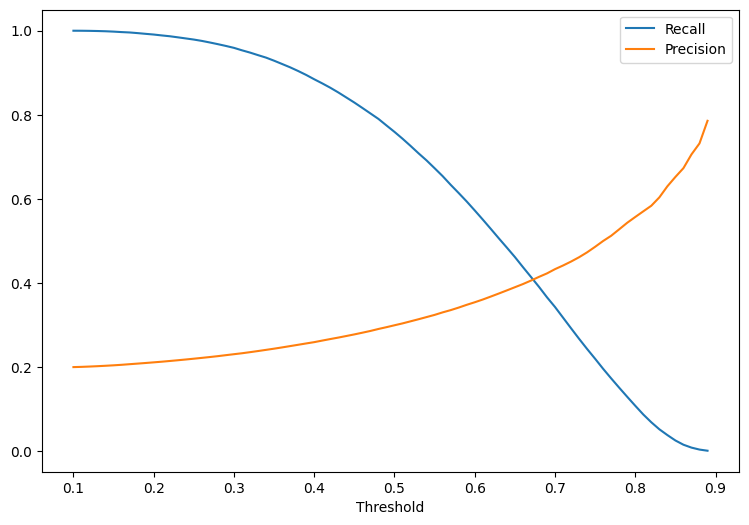

In [8]:
from sklearn.metrics import recall_score, precision_score

thresholds = np.arange(0.1, 0.9, 0.01)
recalls = []
precisions = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recalls.append(recall)
    precisions.append(precision)

plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.legend();
plt.xlabel("Threshold");
plt.show()


### Calibrating probabilities

In [9]:
from sklearn.calibration import CalibratedClassifierCV
cal_model = CalibratedClassifierCV(xgb, method='isotonic', cv='prefit')
cal_model.fit(X_train, y_train)
cal_pred_probs = cal_model.predict_proba(X_test)[:,1]

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


### Threshold optimization

In [10]:
results = pd.DataFrame({
    'pred_pd': cal_pred_probs,
    'actual': y_test.values,
    'loan_amnt': model_df.loc[X_test.index, 'loan_amnt'],
    'int_rate': model_df.loc[X_test.index, 'int_rate'] / 100
})
results.sort_values('pred_pd', inplace=True)




*   Optimized threshold using **Bad rate**, Bad rate is the percentage of approved loans that end up defaulting
*   goal is to find the maximum approval threshold that keeps the predicted bad rate below a strict target (e.g., 10%), while also ensuring that enough loans are approved for platform viability (e.g., at least 5% approval rate)



In [11]:
thresholds = np.linspace(0, 1, 101)
approval_rates, bad_rates = [], []

for t in thresholds:
    approved = results[results['pred_pd'] <= t]
    approval_rates.append(len(approved) / len(results))
    if len(approved) > 0:
        bad_rates.append(approved['actual'].mean())
    else:
        bad_rates.append(np.nan)

In [12]:
target_bad_rate = 0.10
min_approval_rate = 0.05

bad_rates_array = np.array(bad_rates)
thresholds_array = np.array(thresholds)
valid_idx = np.where(bad_rates_array <= target_bad_rate)[0]
safe_indices = np.where(
    (bad_rates_array <= target_bad_rate) &
    (np.array(approval_rates) >= min_approval_rate)
)[0]

if len(safe_indices) > 0:
    safe_idx = safe_indices[-1]
    safe_threshold = thresholds_array[safe_idx]
    print(f"Max safe threshold: {safe_threshold:.3f}")
    print(f"Bad rate at cutoff: {bad_rates_array[safe_idx]:.2%}")
    print(f"Approval rate at cutoff: {approval_rates[safe_idx]:.2%}")
else:
    print("No threshold meets target with minimum volume.")

Max safe threshold: 0.170
Bad rate at cutoff: 9.73%
Approval rate at cutoff: 49.35%


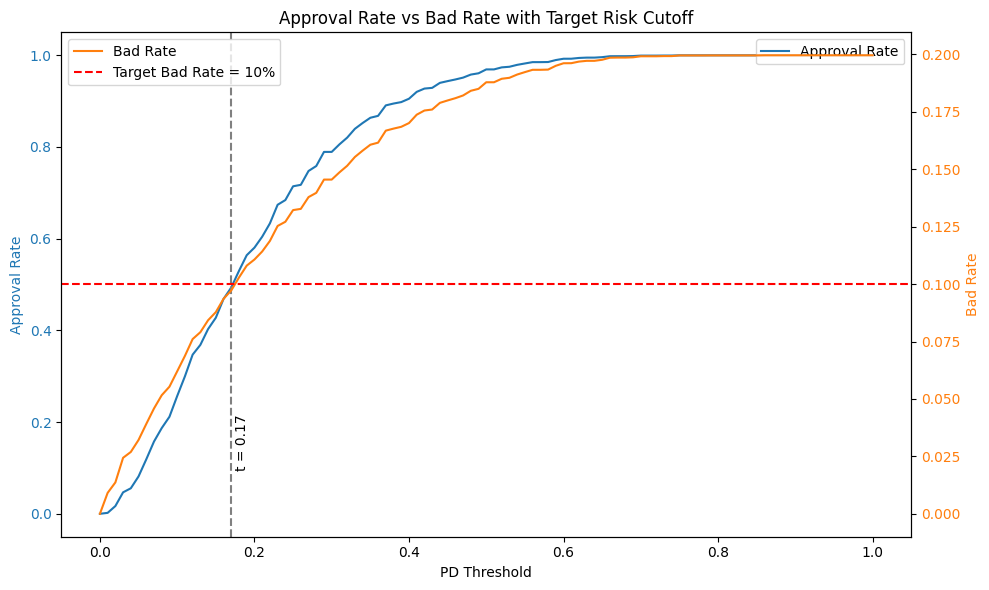

In [13]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Approval rate curve
color1 = 'tab:blue'
ax1.set_xlabel('PD Threshold')
ax1.set_ylabel('Approval Rate', color=color1)
ax1.plot(thresholds, approval_rates, color=color1, label='Approval Rate')
ax1.tick_params(axis='y', labelcolor=color1)
plt.legend(loc='upper right')

# Bad rate curve
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Bad Rate', color=color2)
ax2.plot(thresholds, bad_rates, color=color2, label='Bad Rate')
ax2.tick_params(axis='y', labelcolor=color2)

# Add target bad rate horizontal line
ax2.axhline(target_bad_rate, color='red', linestyle='--', label=f"Target Bad Rate = {target_bad_rate:.0%}")

# Add vertical safe threshold line
if len(safe_indices) > 0:
    ax1.axvline(safe_threshold, color='gray', linestyle='--')
    ax1.text(safe_threshold+0.005, 0.1, f"t = {safe_threshold:.2f}", rotation=90)

plt.title('Approval Rate vs Bad Rate with Target Risk Cutoff')
fig.tight_layout()
plt.legend(loc="upper left")
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score

y_pred_business = (y_proba >= 0.17).astype(int)
cm = confusion_matrix(y_test, y_pred_business)
recall = recall_score(y_test, y_pred_business)
precision = precision_score(y_test, y_pred_business)
roc_auc = roc_auc_score(y_test, y_proba)

print("Confusion Matrix at business threshold:\n", cm)
print(f"Recall: {recall:.2f}, Precision: {precision:.2f}, ROC AUC: {roc_auc:.2f}")


Confusion Matrix at business threshold:
 [[ 10389 204762]
 [   228  53444]]
Recall: 1.00, Precision: 0.21, ROC AUC: 0.72


At t = 0.17, we get:

*  Approval rate: 49%

*  Bad rate: 9.7% (meets target!)

*  Recall: 1.00 (we’re flagging every actual default as “bad” above this threshold)

*  Precision: 0.21 (most “bad” predictions are not actually defaults, but risk is controlled)

*  ROC AUC: ~0.72 (model discriminates risk well overall, matching industry norms for this problem)


---



Re-assigning the grades Based on **PD** so, Investors canchoose grades they’re comfortable with.

In [15]:
results = pd.DataFrame({
    'pred_pd': cal_pred_probs,
    'actual': y_test.values,
    'loan_amnt': model_df.loc[X_test.index, 'loan_amnt'],
    'int_rate': model_df.loc[X_test.index, 'int_rate'] / 100
})
results.sort_values('pred_pd', inplace=True)

def assign_grade(pd):
    if pd <= 0.02: return 'A'
    elif pd <= 0.05: return 'B'
    elif pd <= 0.08: return 'C'
    elif pd <= 0.12: return 'D'
    elif pd <= 0.20: return 'E'
    else: return 'F'

results['grade'] = results['pred_pd'].apply(assign_grade)

In [16]:
results

,pred_pd,actual,loan_amnt,int_rate,grade
881948,0.000000,0,6000.0,0.0532,A
1262225,0.005865,0,10000.0,0.0603,A
1876607,0.005865,0,9600.0,0.0603,A
2151246,0.005865,0,36000.0,0.0532,A
32341,0.005865,0,28000.0,0.0532,A
...,...,...,...,...,...
1570298,0.858156,0,16000.0,0.2677,F
2015652,0.858156,1,11600.0,0.2649,F
1719839,0.858156,1,10525.0,0.3079,F
1708266,0.957001,1,15150.0,0.3074,F


###  Global Explainability

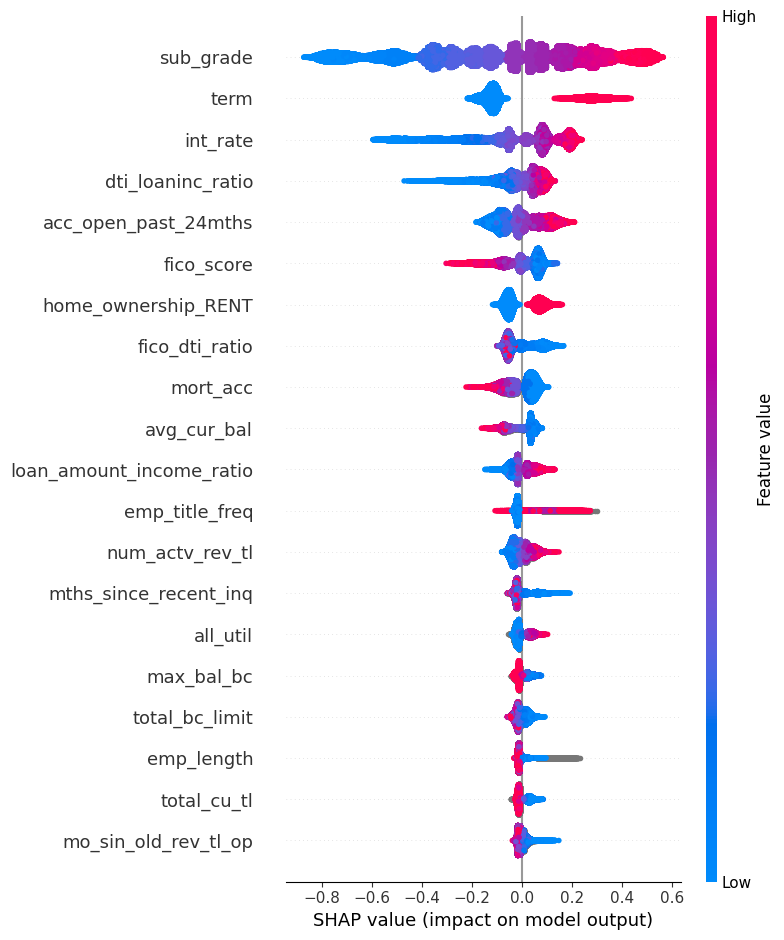

In [17]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())

###  Local Explainability

In [43]:
def explain_loan_decision(model, loan_data, feature_names, pd, threshold=0.17):

    loan_data = loan_data.reshape(1, -1) if loan_data.ndim == 1 else loan_data

    explainer = shap.Explainer(model)

    shap_values = explainer(loan_data)

    shap_values.feature_names = feature_names

    shap.plots.waterfall(shap_values[0],show=False)

    decision = "Approved" if pd <= threshold else "Declined"
    plt.title(f"PD: {pd:.2f} | Business Decision: {decision}", fontsize=14)
    plt.show()

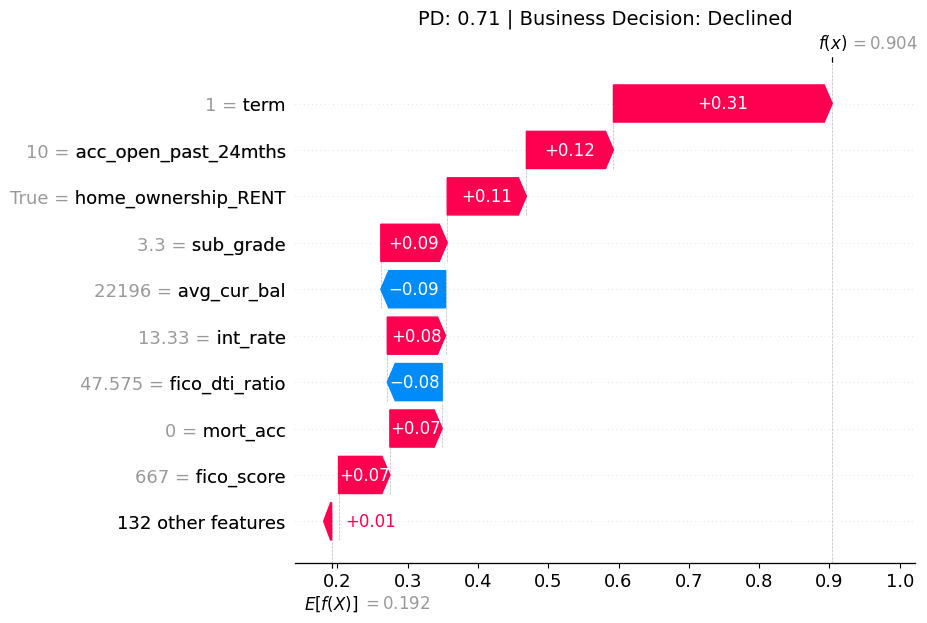

In [45]:
# Example use (for sample index in X_test):
sample_index = 2
explain_loan_decision(xgb, X_test.iloc[sample_index].values, X_test.columns.tolist(),pd=y_proba[sample_index],threshold=0.17)